# Visualize PCA of weight, activity and Estimates MI from data

## Import lib

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.decomposition import PCA

import tqdm

import pickle

# MI estimators
from utils.estimators import *

## Load data

In [9]:
case = 19
temp_load = []
for i in range(case):
    with open(f"data/drop_joint/ZERO_LONG-HEBB-FULL_STATE-seed_0-case_{i}-rand-0.pkl", "rb") as m:
        loaded_zero = pickle.load(m)
        temp_load.append(loaded_zero)

In [4]:
def reshape_to_single(val):
    '''
    Input dim : [timestep , np:[1,dim] ]
    Return dim : np: [timestep , dim]
    '''
    for i in range(len(val)):
        val[i] = val[i].reshape(-1)
    return np.array(val)

In [5]:
def select_activity_layer(activity,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(activity)):
        layer = activity[t][selected_layer]
        buff.append(layer.reshape(-1) if isinstance(layer, np.ndarray) else layer.numpy().reshape(-1))
    return np.array(buff , dtype=object)

In [6]:
def select_weight_layer(weight,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(weight)):
        _b = weight[t][selected_layer][0]
        buff.append(_b if isinstance(_b, np.ndarray) else _b.numpy())
    return np.array(buff , dtype=object)

Load Normal

In [13]:
all_data = []

for load in temp_load:
    temp = {}
    activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
    weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
    temp["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
    temp["pos_x"]       = reshape_to_single(load["data"]["pos_x"])
    temp["pos_y"]       = reshape_to_single(load["data"]["pos_y"])
    temp["torque"]       = reshape_to_single(load["data"]["torque"])
    temp["reward"]       = reshape_to_single(load["data"]["reward"])
    temp["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
    temp["act_hid_2"]   = select_activity_layer(activity , 1)
    temp["weight_hid_1"] = select_weight_layer(weight,0)
    temp["weight_hid_2"] = select_weight_layer(weight,1)
    temp["weight_hid_3"] = select_weight_layer(weight,2)
    temp["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
    all_data.append(temp)

get Max distance

In [20]:
buf = []
for joint_index in all_data:
    buf.append(np.max(joint_index["pos_x"], axis=0))
buf = np.array(buf)

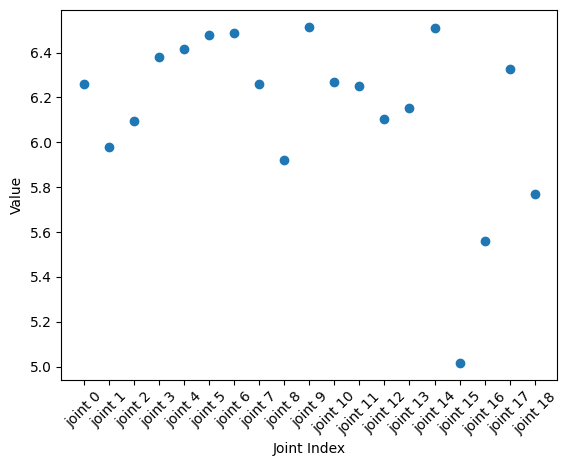

In [25]:
plt.figure()
x_lab = [f"joint {i}" for i in range(len(all_data))]  # Labels for the x-axis
plt.scatter(x_lab, buf)  # Pass x_lab as the x-values and buf as the y-values
# Set labels for x and y axes
plt.xlabel('Joint Index')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()  # Ensure the plot is displayed